In [2]:
import datetime
import pyaurorax
import cartopy.crs

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

### **Step 1: Download and Read Necessary Data**

***We will download THEMIS, TREx RGB, and REGO data here.***

In [3]:
# Keep imagers with data at different altitude separate
data_list_110km = []
data_list_230km = []

# download a minute of RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = start_dt
rgb_site_uid_list = ['yknf', 'gill', 'rabb', 'luck']
data_download_objs = {}
for site_uid in rgb_site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# Read in the data site-by-site, as we need this separation for mosaicing
for site_uid, download_obj in data_download_objs.items():
    data_list_110km.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

# Now download a minute of THEMIS data from the same time
dataset_name = "THEMIS_ASI_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = start_dt
themis_site_uid_list = ['fsmi', 'atha']
data_download_objs = {}
for site_uid in themis_site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# Read in and append to the SAME data_list
for site_uid, download_obj in data_download_objs.items():
    data_list_110km.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

# Now download a minute of REGO data from the same time
dataset_name = "REGO_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = start_dt
rego_site_uid_list = ['rank']
data_download_objs = {}
for site_uid in rego_site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# Read in and append to the SAME data_list
for site_uid, download_obj in data_download_objs.items():
    data_list_230km.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

### **Step 2: Download Skymaps**

In [4]:
# Initialize our total skymap data lists seperately for imagers with data at different altitudes
skymaps_110km = []
skymaps_230km = []

# Get the recommended skymap for RGB data, read it in
for site_uid in rgb_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("TREX_RGB_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps_110km.append(skymap.data[0])

# Get the recommended skymap for THEMIS data, read it in
skymap_download_objs = {}
for site_uid in themis_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("THEMIS_ASI_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps_110km.append(skymap.data[0])

# Get the recommended skymap for THEMIS data, read it in
skymap_download_objs = {}
for site_uid in rego_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("REGO_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps_230km.append(skymap.data[0])

### **Step 3: Prep Skymap and Image Data**

In [5]:
# prepare the skymap data separately for THEMIS/TREX RGB and REGO as they're at different altitudes
prepped_skymap_110km = at.mosaic.prep_skymaps(skymaps_110km, 110, n_parallel=5)
prepped_skymap_230km = at.mosaic.prep_skymaps(skymaps_230km, 230, n_parallel=5)

Preparing skymaps:   0%|          | 0/6 [00:00<?, ?skymap/s]

Preparing skymaps:   0%|          | 0/1 [00:00<?, ?skymap/s]

In [6]:
# prepare the image data
prepped_images_110km = at.mosaic.prep_images(data_list_110km)
prepped_images_230km = at.mosaic.prep_images(data_list_230km)

### **Step 4: Generate the Mosaic**

In [7]:
# define the intensity scales for each site
scale = {
    "yknf": [10, 105],  # RGB sites
    "gill": [10, 105],
    "rabb": [10, 105],
    "luck": [10, 105],
    "atha": [3500, 14000],  # THEMIS sites
    "fsmi": [3500, 14000],
    "rank": [250, 1500]  # REGO site
}

# Set timestamp to actually create mosaic frame for
mosaic_dt = datetime.datetime(2023, 2, 24, 6, 15, 3)

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# Create lists for inputs - all in same order, of which plotting will occur
prepped_images_list = [prepped_images_230km, prepped_images_110km]
prepped_skymap_list = [prepped_skymap_230km, prepped_skymap_110km]
min_elevation_list = [10, 5]

mosaic = at.mosaic.create(prepped_images_list,
                          prepped_skymap_list,
                          mosaic_dt,
                          projection_obj,
                          image_intensity_scales=scale,
                          colormap=['gist_heat', 'gray'],
                          min_elevation=min_elevation_list)
print(mosaic)

Mosaic(polygon_data=[PolyCollection(...), ...], cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


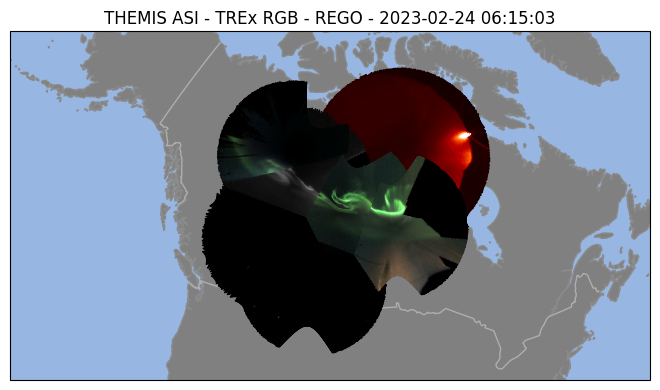

In [8]:
# plot mosaic
map_extent = [-145, -65, 35, 70]
mosaic.plot(map_extent, title="THEMIS ASI - TREx RGB - REGO - %s" % (mosaic_dt.strftime("%Y-%m-%d %H:%M:%S")))